### **Import Libraries**

In [15]:
# Import Libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.utils import to_categorical


In [4]:
# Extract ZIP Dataset
zip_path = "MobiFall_Dataset.zip"
extract_path = "MobiFall_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted!")
print(os.listdir(extract_path))


Dataset extracted!
['MobiFall_Dataset_v2.0']


### **Dataset Paths & Classes**

In [5]:
# Dataset Paths & Classes
root_path = os.path.join(extract_path, "MobiFall_Dataset_v2.0", "sub10")

activities = {
    "STD": "Standing",
    "SCH": "Sitting",
    "WAL": "Walking",
    "BSC": "Back_Sitting_Chair",
    "FOL": "Fall_Forward_Lying",
    "SDL": "Sideward_Lying"
}

parent_map = {
    "ADL": ["STD", "SCH", "WAL"],
    "FALLS": ["BSC", "FOL", "SDL"]
}

print("sub10 folders:", os.listdir(root_path))


sub10 folders: ['FALLS', 'ADL']


### **Dataset Loading**

In [6]:
# Load & Parse .txt Files
data_list = []

for parent, subs in parent_map.items():
    for sub in subs:
        folder = os.path.join(root_path, parent, sub)
        for file in os.listdir(folder):
            if file.endswith(".txt"):
                file_path = os.path.join(folder, file)

                # Skip headers, read only data after @DATA
                with open(file_path, 'r') as f:
                    lines = f.readlines()
                    start_idx = lines.index("@DATA\n") + 1

                df = pd.read_csv(
                    file_path,
                    skiprows=start_idx,
                    header=None
                )

                df.columns = ["timestamp", "accX", "accY", "accZ"]
                df["label"] = activities[sub]

                data_list.append(df)

data = pd.concat(data_list, ignore_index=True)

print("Data shape:", data.shape)
print("Classes:", data["label"].unique())


Data shape: (355313, 5)
Classes: ['Standing' 'Sitting' 'Walking' 'Back_Sitting_Chair' 'Fall_Forward_Lying'
 'Sideward_Lying']


### **Data Preprocessing**

In [9]:
# Preprocessing
# Convert timestamp to datetime
data["timestamp"] = pd.to_datetime(data["timestamp"], unit='ns')

# Sort by time
data = data.sort_values("timestamp")

# Missing values
print("Missing values:", data.isnull().sum().sum())
data = data.ffill()

# Remove duplicates
data = data.drop_duplicates()

# Count duplicate rows
duplicate_rows = data.duplicated().sum()
print("Number of duplicate rows:", duplicate_rows)

print("Final shape after preprocessing:", data.shape)


Missing values: 0
Number of duplicate rows: 0
Final shape after preprocessing: (355313, 5)


### **Feature Selection & Label Encoding**

In [10]:
# Feature Selection & Label Encoding
features = ["accX", "accY", "accZ"]
X = data[features].values
y = data["label"].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Class mapping:")
for i, cls in enumerate(label_encoder.classes_):
    print(i, "->", cls)

num_classes = len(label_encoder.classes_)
y_cat = to_categorical(y_encoded, num_classes)


Class mapping:
0 -> Back_Sitting_Chair
1 -> Fall_Forward_Lying
2 -> Sideward_Lying
3 -> Sitting
4 -> Standing
5 -> Walking


### **Train-Test Split**

In [11]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_cat,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)


### **Feature Scaling**

In [12]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### **Build Fully Connected Neural Network**

In [16]:

# Build Fully Connected Neural Network
model = Sequential()

# Input layer to define the entry point
model.add(Input(shape=(X_train.shape[1],)))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,566 (166.27 KB)

 Trainable params: 42,566 (166.27 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Training
history = model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/30
7107/7107 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.7252 - loss: 0.7809 - val_accuracy: 0.8639 - val_loss: 0.4893
Epoch 2/30
7107/7107 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8502 - loss: 0.5193 - val_accuracy: 0.8774 - val_loss: 0.4400
Epoch 3/30
7107/7107 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.8646 - loss: 0.4784 - val_accuracy: 0.8852 - val_loss: 0.4172
Epoch 4/30
7107/7107 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8713 - loss: 0.4585 - val_accuracy: 0.8874 - val_loss: 0.4032
Epoch 5/30
7107/7107 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8748 - loss: 0.4443 - val_accuracy: 0.8902 - val_loss: 0.3968
Epoch 6/30
7107/7107 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8779 - loss: 0.4326 - val_accuracy: 0.8886 - val_loss: 0.3928
Epoch 7/30
7107/7107 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.8792 - loss: 0.4266 - val_accuracy: 0.8920 - val_loss: 0.3902
Epoch 8/30
7107/7107 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8807 - loss: 0

### **Evaluate Model**

In [18]:
# Evaluate Model
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Macro F1:", f1_score(y_true, y_pred, average="macro"))

print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=label_encoder.classes_
))


2221/2221 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Accuracy: 0.9005108143478322
Macro F1: 0.7259105407206049

Classification Report:

                    precision    recall  f1-score   support

Back_Sitting_Chair       0.97      0.53      0.69      2904
Fall_Forward_Lying       0.75      0.46      0.57      2889
    Sideward_Lying       0.93      0.42      0.58      2908
           Sitting       0.90      0.49      0.63      3493
          Standing       0.89      1.00      0.94     29187
           Walking       0.92      0.98      0.95     29682

          accuracy                           0.90     71063
         macro avg       0.89      0.65      0.73     71063
      weighted avg       0.90      0.90      0.89     71063



### **Confusion Matrix**

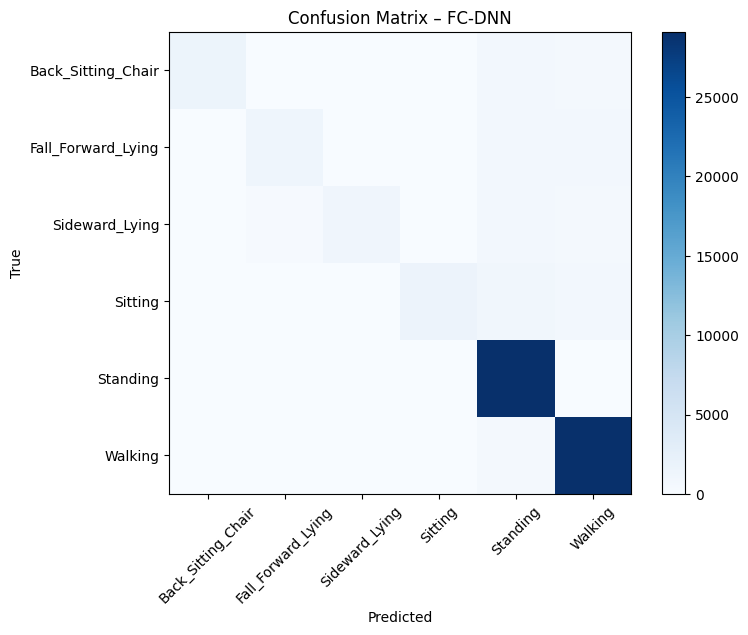

In [19]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(range(num_classes), label_encoder.classes_, rotation=45)
plt.yticks(range(num_classes), label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – FC-DNN")
plt.show()


### **Graphical Representation**

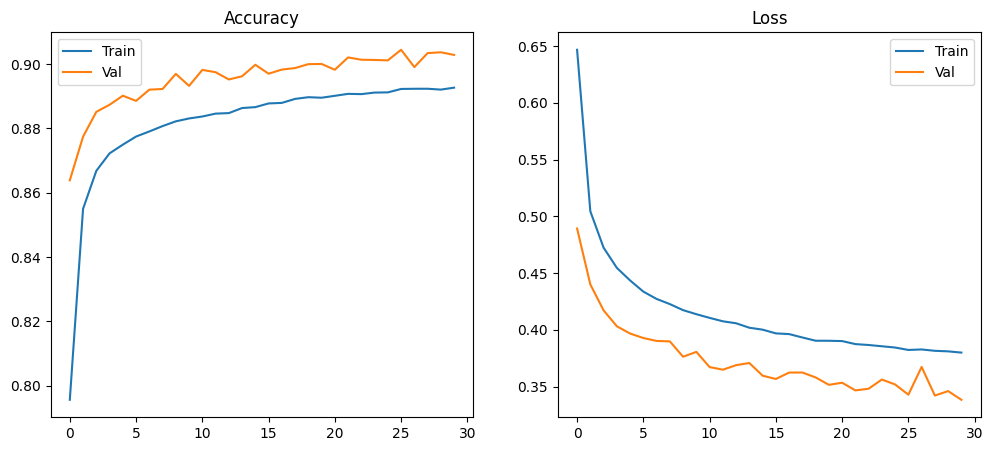

In [20]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()

plt.show()
